In [4]:
using CairoMakie
using JLD2
using Oceananigans

[ Info: Oceananigans will use 4 threads


In [57]:
foldername = "../scratch/filament-instability/Ro1Ri1Ek0"
filename = "down_front_mean.jld2"
grid = jldopen("$foldername/$filename") do file
    file["serialized/grid"]
end;
xᶜᵃᵃ = xnodes(Center, grid)
zᵃᵃᶜ = znodes(Center, grid)
@inline function ∂zᶜᶜᶜ(aᶜᶜᶜ, Δzᵃᵃᶜ)
    let ∂zaᶜᶜᶜ = (aᶜᶜᶜ - circshift(aᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
        ∂zaᶜᶜᶜ[:, 1] .= ∂zaᶜᶜᶜ[:, 2]
    ∂zaᶜᶜᶜ
    end
end
@inline function ∂xᶜᶜᶜ(aᶜᶜᶜ, Δx)
    (circshift(aᶜᶜᶜ, (-1, 0)) - circshift(aᶜᶜᶜ, (1, 0))) ./ (2Δx)
end

@inline function down_front_momentum(runname, n)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    fluxfilename = "turbulent_flux.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
        end;
    frame = frames[n]
    
    xᶜᵃᵃ = xnodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
    
    
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    
    file = jldopen("$foldername/$filename")
    fluxfile = jldopen("$foldername/$fluxfilename")
    
    u = file["timeseries/u_dfm/$frame"][:, 1, :]
    v = file["timeseries/v_dfm/$frame"][:, 1, :]
    w = (file["timeseries/w_dfm/$frame"][:, 1, 2:end] .+ file["timeseries/w_dfm/$frame"][:, 1, 1:end-1])/2
    
    v_flux = (fluxfile["timeseries/vFLUX/$frame"][:, 1, 2:end] .+ fluxfile["timeseries/vFLUX/$frame"][:, 1, 1:end-1])/2
    ∂tv = (file["timeseries/v_dfm/$(frames[n+1])"][:, 1, :] .- file["timeseries/v_dfm/$frame"][:, 1, :]) / (file["timeseries/t/$(frames[n+1])"] - file["timeseries/t/$frame"])
    Dtv = ∂tv .+ u.*∂xᶜᶜᶜ(v, Δx) .+ w.*∂zᶜᶜᶜ(v, Δzᵃᵃᶜ)
    return (Dtv, sp.f * u, ∂zᶜᶜᶜ(v_flux, Δzᵃᵃᶜ))
end

down_front_momentum (generic function with 1 method)

In [70]:
a = down_front_momentum("Ro1Ri02Ek0", 800);

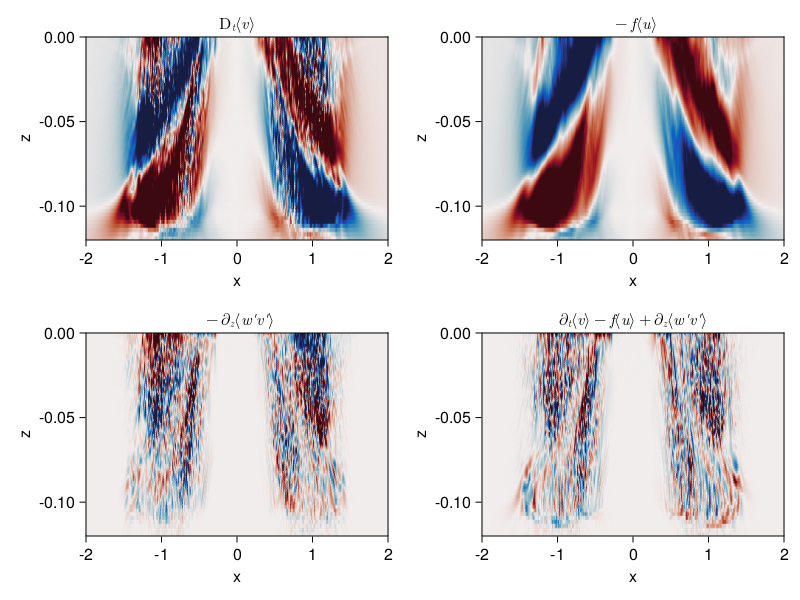

In [71]:
fig = Figure()

ax_∂tv = Axis(fig[1, 1]; title=L"\text{D}_t \langle v\rangle", limits=(-2, 2, -0.12, 0), xlabel="x", ylabel="z")
ax_fu = Axis(fig[1, 2]; title=L"-f \langle u\rangle", limits=(-2, 2, -0.12, 0), xlabel="x", ylabel="z")
ax_vFLUX = Axis(fig[2, 1]; title=L"-\partial_z \langle w'v'\rangle", limits=(-2, 2, -0.12, 0), xlabel="x", ylabel="z")
ax_sum = Axis(fig[2, 2]; title=L"\partial_t \langle v\rangle -f \langle u\rangle + \partial_z \langle w'v'\rangle", limits=(-2, 2, -0.12, 0), xlabel="x", ylabel="z")

heatmap!(ax_∂tv, xᶜᵃᵃ, zᵃᵃᶜ, a[1]; colormap=:balance, colorrange=(-0.1, 0.1))
heatmap!(ax_fu, xᶜᵃᵃ, zᵃᵃᶜ, -a[2]; colormap=:balance, colorrange=(-0.1, 0.1))
heatmap!(ax_vFLUX, xᶜᵃᵃ, zᵃᵃᶜ, -a[3]; colormap=:balance, colorrange=(-0.1, 0.1))
heatmap!(ax_sum, xᶜᵃᵃ, zᵃᵃᶜ, a[1] .+ a[2] .+ a[3]; colormap=:balance, colorrange=(-0.1, 0.1))
fig